In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

In [2]:
from main import *
from multiprocessing import Pool
import pandas as pd

In [15]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

sys.path.append("..")
from swarmalatorlib.template import Swarmalators2D


class SpatialGroups(Swarmalators2D):
    def __init__(self, strengthLambda: float, distanceD0: float, boundaryLength: float = 10, 
                 omegaTheta2Shift: float = 0, agentsNum: int=1000, dt: float=0.01, 
                 tqdm: bool = False, savePath: str = None, shotsnaps: int = 5, 
                 uniform: bool = True, randomSeed: int = 10, overWrite: bool = False) -> None:
        np.random.seed(randomSeed)
        self.positionX = np.random.random((agentsNum, 2)) * 10
        self.phaseTheta = np.random.random(agentsNum) * 2 * np.pi - np.pi
        self.agentsNum = agentsNum
        self.dt = dt
        self.speedV = 0.03
        self.distanceD0 = distanceD0
        if uniform:
            self.omegaTheta = np.concatenate([
                np.random.uniform(1, 3, size=agentsNum // 2),
                np.random.uniform(-3, -1, size=agentsNum // 2)
            ])
        else:
            self.omegaTheta = np.concatenate([
                np.random.normal(loc=3, scale=0.5, size=agentsNum // 2),
                np.random.normal(loc=-3, scale=0.5, size=agentsNum // 2)
            ])
        self.uniform = uniform
        self.strengthLambda = strengthLambda
        self.tqdm = tqdm
        self.savePath = savePath
        self.temp = np.zeros(agentsNum)
        self.shotsnaps = shotsnaps
        self.counts = 0
        self.omegaTheta[:self.agentsNum // 2] += omegaTheta2Shift
        self.omegaTheta2Shift = omegaTheta2Shift
        self.boundaryLength = boundaryLength
        self.halfBoundaryLength = boundaryLength / 2
        self.randomSeed = randomSeed
        self.overWrite = overWrite

    @property
    def K(self):
        return self.distance_x(self.deltaX) <= self.distanceD0

    @property
    def deltaX(self) -> np.ndarray:
        return self._delta_x(self.positionX, self.positionX[:, np.newaxis], 
                             self.boundaryLength, self.halfBoundaryLength)

    @staticmethod
    @nb.njit
    def _delta_x(positionX: np.ndarray, others: np.ndarray,
                 boundaryLength: float, halfBoundaryLength: float) -> np.ndarray:
        subX = positionX - others
        return positionX - (
            others * (-halfBoundaryLength <= subX) * (subX <= halfBoundaryLength) + 
            (others - boundaryLength) * (subX < -halfBoundaryLength) + 
            (others + boundaryLength) * (subX > halfBoundaryLength)
        )

    @property
    def pointTheta(self):
        return self._pointTheta(self.phaseTheta, self.omegaTheta, self.strengthLambda, self.dt, self.K)

    @staticmethod
    @nb.njit
    def _pointTheta(phaseTheta: np.ndarray, omegaTheta: np.ndarray, strengthLambda: float, 
                    h: float, K: np.ndarray):
        adjMatrixTheta = np.repeat(phaseTheta, phaseTheta.shape[0]).reshape(phaseTheta.shape[0], phaseTheta.shape[0])
        k1 = omegaTheta + strengthLambda * np.sum(K * np.sin(
            adjMatrixTheta - phaseTheta
        ), axis=0)
        return k1 * h

    def append(self):
        if self.store is not None:
            if self.counts % self.shotsnaps != 0:
                return
            self.store.append(key="positionX", value=pd.DataFrame(self.positionX))
            self.store.append(key="phaseTheta", value=pd.DataFrame(self.phaseTheta))
            self.store.append(key="pointTheta", value=pd.DataFrame(self.temp))

    def update(self):
        self.positionX[:, 0] += self.speedV * np.cos(self.phaseTheta)
        self.positionX[:, 1] += self.speedV * np.sin(self.phaseTheta)
        self.positionX = np.mod(self.positionX, 10)
        self.temp = self.pointTheta
        self.phaseTheta += self.temp
        self.phaseTheta = np.mod(self.phaseTheta + np.pi, 2 * np.pi) - np.pi

    def __str__(self) -> str:
        
        if self.uniform:
            name =  f"CorrectCoupling_uniform_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"
        else:
            name =  f"CorrectCoupling_normal_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"

        if self.omegaTheta2Shift != 0:
            name += f"_shift_{self.omegaTheta2Shift:.2f}"

        return name

    def close(self):
        if self.store is not None:
            self.store.close()

    
class CorrectCouplingAfter(SpatialGroups):
    def __init__(self, strengthLambda: float, distanceD0: float, boundaryLength: float = 10,
                 omegaTheta2Shift: float = 0, agentsNum: int=1000, dt: float=0.01, 
                 tqdm: bool = False, savePath: str = None, shotsnaps: int = 5, 
                 uniform: bool = True, randomSeed: int = 10, overWrite: bool = False) -> None:
        super().__init__(strengthLambda, distanceD0, boundaryLength, omegaTheta2Shift, 
                         agentsNum, dt, tqdm, savePath, shotsnaps, uniform, randomSeed, overWrite)

        targetPath = f"./data/{self.oldName}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")

        TNum = totalPositionX.shape[0] // self.agentsNum
        totalPositionX = totalPositionX.values.reshape(TNum, self.agentsNum, 2)
        totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, self.agentsNum)
        
        self.positionX = totalPositionX[-1]
        self.phaseTheta = totalPhaseTheta[-1]

    @property
    def oldName(self) -> str:
        
        if self.uniform:
            name =  f"CorrectCoupling_uniform_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"
        else:
            name =  f"CorrectCoupling_normal_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"

        if self.omegaTheta2Shift != 0:
            name += f"_shift_{self.omegaTheta2Shift:.2f}"

        return name

    def __str__(self) -> str:
            
            if self.uniform:
                name =  f"CorrectCouplingAfter_uniform_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"
            else:
                name =  f"CorrectCouplingAfter_normal_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"
    
            return name
    
    def run(self, enhancedLambdas: np.ndarray):

        if not self.init_store():
            return
        
        TNum = enhancedLambdas.shape[0]
        if self.tqdm:
            iterRange = tqdm(range(TNum))
        else:
            iterRange = range(TNum)

        for idx in iterRange:
            self.strengthLambda = enhancedLambdas[idx]
            self.update()
            self.append()
            self.counts = idx

        self.close()


class SingleDistribution(SpatialGroups):
    def __init__(self, strengthLambda: float, distanceD0: float, boundaryLength: float = 10, 
                 agentsNum: int=500, dt: float=0.01, 
                 tqdm: bool = False, savePath: str = None, shotsnaps: int = 5, 
                 uniform: bool = True, randomSeed: int = 10, overWrite: bool = False) -> None:
        np.random.seed(randomSeed)
        self.positionX = np.random.random((agentsNum, 2)) * 10
        self.phaseTheta = np.random.random(agentsNum) * 2 * np.pi - np.pi
        self.agentsNum = agentsNum
        self.dt = dt
        self.speedV = 0.03
        self.distanceD0 = distanceD0
        if uniform:
            self.omegaTheta = np.random.uniform(1, 3, size=agentsNum)
        else:
            self.omegaTheta = np.random.normal(loc=3, scale=0.5, size=agentsNum)
        self.uniform = uniform
        self.strengthLambda = strengthLambda
        self.tqdm = tqdm
        self.savePath = savePath
        self.temp = np.zeros(agentsNum)
        self.shotsnaps = shotsnaps
        self.counts = 0
        self.boundaryLength = boundaryLength
        self.halfBoundaryLength = boundaryLength / 2
        self.randomSeed = randomSeed
        self.overWrite = overWrite

    def __str__(self) -> str:
        
        if self.uniform:
            name =  f"SingleDistribution_uniform_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"
        else:
            name =  f"SingleDistribution_normal_{self.strengthLambda:.3f}_{self.distanceD0:.2f}_{self.randomSeed}"

        return name
        

class RingStateAnalysis:
    def __init__(self, model: SpatialGroups, classDistance: float = 2, classIndex: int = -1, tqdm: bool = True):
        self.model = model
        self.classDistance = classDistance
        self.classIndex = classIndex
        self.tqdm = tqdm
        
        targetPath = f"{self.model.savePath}/{self.model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
        
        TNum = totalPositionX.shape[0] // self.model.agentsNum

        self.totalPositionX = totalPositionX.values.reshape(TNum, self.model.agentsNum, 2)
        self.totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, self.model.agentsNum)
        self.totalPointTheta = totalPointTheta.values.reshape(TNum, self.model.agentsNum)

        self.centersValue = None
        self.classesValue = None

    def get_state(self, index: int = -1):
        positionX = self.totalPositionX[index]
        phaseTheta = self.totalPhaseTheta[index]
        pointTheta = self.totalPointTheta[index]

        return positionX, phaseTheta, pointTheta
    
    # @staticmethod
    # @nb.njit
    # def _calc_centers(positionX, phaseTheta, pointTheta, speedV):
    #     centers = np.zeros((positionX.shape[0], 2))

    #     for i in range(positionX.shape[0]):
    #         counts = max(200, abs(2 * np.pi // pointTheta[i]))
    #         phaseChanges = np.arange(0, counts * pointTheta[i], pointTheta[i])

    #         trackX = positionX[i, 0] + np.cumsum(speedV * np.cos(phaseTheta[i] + phaseChanges))
    #         trackY = positionX[i, 1] + np.cumsum(speedV * np.sin(phaseTheta[i] + phaseChanges))

    #         centers[i, 0] = np.mean(trackX)  # np.sum(np.array([trackX, trackY]), axis=1) / counts
    #         centers[i, 1] = np.mean(trackY)  

    #     return centers

    @staticmethod
    @nb.njit
    def _calc_centers(positionX, phaseTheta, pointTheta, speedV):
        centers = np.zeros((positionX.shape[0], 2))

        for i in range(positionX.shape[0]):
            position, phase, point = positionX[i], phaseTheta[i], pointTheta[i]
            point1 = position
            velocity1 = speedV * np.array([np.cos(phase), np.sin(phase)])
            point2 = position + velocity1
            velocity2 = speedV * np.array([np.cos(phase + point), np.sin(phase + point)])

            unit_velocity1 = velocity1 / np.linalg.norm(velocity1)
            unit_velocity2 = velocity2 / np.linalg.norm(velocity2)

            coefficients = np.array([
                [unit_velocity1[0], unit_velocity1[1]],
                [unit_velocity2[0], unit_velocity2[1]]
            ])

            constants = np.array([
                np.sum(unit_velocity1 * point1),
                np.sum(unit_velocity2 * point2)
            ])

            center = np.linalg.solve(coefficients, constants)

            centers[i] = center

        return centers

    @property
    def centers(self):
        
        lastPositionX, lastPhaseTheta, lastPointTheta = self.get_state(self.classIndex)
        
        centers = self._calc_centers(
            lastPositionX, lastPhaseTheta, lastPointTheta, self.model.speedV
        )

        return np.mod(centers, self.model.boundaryLength)

    @property
    def centersNoMod(self):
            
        lastPositionX, lastPhaseTheta, lastPointTheta = self.get_state(self.classIndex)
        
        centers = self._calc_centers(
            lastPositionX, lastPhaseTheta, lastPointTheta, self.model.speedV
        )

        return centers
         
    
    def adj_distance(self, positionX, others):
        return self._adj_distance(
            positionX, others, self.model.boundaryLength, self.model.halfBoundaryLength
        )

    @staticmethod
    @nb.njit
    def _adj_distance(positionX, others, boundaryLength, halfLength):
        subX = positionX - others
        adjustOthers = (
            others * (-halfLength <= subX) * (subX <= halfLength) + 
            (others - boundaryLength) * (subX < -halfLength) + 
            (others + boundaryLength) * (subX > halfLength)
        )
        adjustSubX = positionX - adjustOthers
        return np.sqrt(np.sum(adjustSubX ** 2, axis=-1))
    
    @staticmethod
    @nb.njit
    def _calc_classes(centers, classDistance, totalDistances):
        classes = [[0]]
        classNum = 0
        nonClassifiedOsci = np.arange(1, centers.shape[0])

        for i in nonClassifiedOsci:
            newClass = True

            for classI in range(len(classes)):
                distance = classDistance
                for j in classes[classI]:
                    if totalDistances[i, j] < distance:
                        distance = totalDistances[i, j]
                if distance < classDistance:
                    classes[classI].append(i)
                    newClass = False
                    break

            if newClass:
                classNum += 1
                classes.append([i])

        return classes

    def get_classes_centers(self):
        centers = self.centers
        classes = self._calc_classes(
            centers, self.classDistance, self.adj_distance(centers, centers[:, np.newaxis])
        )
        return {i + 1: classes[i] for i in range(len(classes))}, centers

    def plot_spatial(self, ax: plt.Axes = None, oscis: np.ndarray = None, index: int = -1, **kwargs):
        positionX, phaseTheta, pointTheta = self.get_state(index)

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        if oscis is None:
            oscis = np.arange(self.model.agentsNum)

        ax.quiver(
            positionX[oscis, 0], positionX[oscis, 1],
            np.cos(phaseTheta[oscis]), np.sin(phaseTheta[oscis]), **kwargs
        )
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)    

    def plot_centers(self, ax: plt.Axes = None, index: int = -1):
        positionX, phaseTheta, pointTheta = self.get_state(index)

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        quiverColors = ["tomato"] * 500 + ["dodgerblue"] * 500
        ax.quiver(
            positionX[:, 0], positionX[:, 1],
            np.cos(phaseTheta[:]), np.sin(phaseTheta[:]), color=quiverColors, alpha=0.5
        )
        centerColors = ["orange"] * 500 + ["blue"] * 500
        centers = self.centers
        ax.scatter(centers[:, 0], centers[:, 1], color=centerColors, s=5)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)    

    def r_order_parameter(self, classOsci: np.ndarray):
        thetas = self.totalPhaseTheta[:, classOsci]
        r =(
            (np.sum(np.sin(thetas), axis=1) / self.model.agentsNum)**2 + 
            (np.sum(np.cos(thetas), axis=1) / self.model.agentsNum)**2
        )**0.5
        return r

    def trapping_ratio_order_paparameter(self, classOsci: np.ndarray, radius: float = 1.5):
        tr = np.zeros(self.totalPhaseTheta.shape[0])
        
        for i in range(self.totalPhaseTheta.shape[0]):
            center = self.totalPositionX[i, classOsci].mean(axis=0)
            tr[i] = np.sum(
                self.adj_distance(center, self.totalPositionX[i, classOsci]) < radius
            )
        return tr
    
    def center_distances_order_paparameter(self, classOsci: np.ndarray):
        centers = self.centers
        return self.adj_distance(centers[classOsci], centers[classOsci][:, np.newaxis]).mean(axis=1)
    
    def center_radius_order_paparameter(self, classOsci: np.ndarray):
        centers = self.centers
        return self.adj_distance(centers[classOsci], self.totalPositionX[:, classOsci]).mean(axis=1)
    
    def time_varying_center_distances_order_paparameter(self, step: int = 10):
        centerRadios = []

        if self.tqdm:
            iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            iterObject = range(1, self.totalPhaseTheta.shape[0])

        for i in iterObject:
            if i % step != 0:
                continue
            self.classIndex = i
            centers = self.centersNoMod
            # rawDis = np.sqrt(np.sum((centers - self.totalPositionX[i]) ** 2, axis=-1))
            # print(rawDis.max())
            modCenters = np.mod(centers, self.model.boundaryLength)
            distance = self.adj_distance(modCenters, self.totalPositionX[i])
            d = np.mean(distance)
            centerRadios = centerRadios + [d] * step

        return np.array(centerRadios)

    def time_varying_class_center_distances(self, step: int = 10):
        t = []
        centerRadios = []

        if self.tqdm:
            iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            iterObject = range(1, self.totalPhaseTheta.shape[0])

        for i in iterObject:
            if i % step != 0:
                continue
            self.classIndex = i
            
            classes, centers = self.get_classes_centers()
            
            for classIdx in classes:
                classOscis = np.array(classes[classIdx])
                if len(classOscis) < 5:
                    continue
                center = centers[classIdx]
                distance = self.adj_distance(center, self.totalPositionX[i][classOscis])
                d = np.mean(distance)
                centerRadios.append(d)
                t.append(i)

        return np.array([t, centerRadios]).T

    def time_varying_class_center_position(self, step: int = 10):
        t = []
        positionX = []
        positionY = []

        if self.tqdm:
            iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            iterObject = range(1, self.totalPhaseTheta.shape[0])

        for i in iterObject:
            if i % step != 0:
                continue
            self.classIndex = i

            classes, centers = self.get_classes_centers()

            for classIdx in classes:
                classOscis = np.array(classes[classIdx])
                if len(classOscis) < 5:
                    continue
                center = centers[classOscis].mean(axis=0)

                positionX.append(center[0])
                positionY.append(center[1])
                t.append(i)

        return np.array([t, positionX, positionY]).T
    
    def time_varying_center_position(self, step: int = 10):
        color = ["tomato"] * 500 + ["dodgerblue"] * 500

        t = []
        positionX = []
        positionY = []
        colors = []

        if self.tqdm:
            iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            iterObject = range(1, self.totalPhaseTheta.shape[0])

        for i in iterObject:
            if i % step != 0:
                continue
            self.classIndex = i

            centers = self.centers
            t.append(np.ones(self.model.agentsNum) * i)
            positionX.append(centers[:, 0])
            positionY.append(centers[:, 1])
            colors.append(color)

        t = np.concatenate(t, axis=0)
        positionX = np.concatenate(positionX, axis=0)
        positionY = np.concatenate(positionY, axis=0)
        colors = np.concatenate(colors, axis=0)

        return np.array([t, positionX, positionY]).T, colors

    def time_varying_center_distances(self, step: int = 10):
        
        color = ["tomato"] * 500 + ["dodgerblue"] * 500

        t = []
        centerDis = []
        colors = []

        if self.tqdm:
            iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            iterObject = range(1, self.totalPhaseTheta.shape[0])

        for i in iterObject:
            if i % step != 0:
                continue
            self.classIndex = i

            centers = self.centers
            t.append(np.ones(self.model.agentsNum) * i)
            centerDis.append(self.adj_distance(self.totalPositionX[i], centers))
            colors.append(color)

        t = np.concatenate(t, axis=0)
        centerDis = np.concatenate(centerDis, axis=0)
        colors = np.concatenate(colors, axis=0)

        return np.array([t, centerDis]).T, colors

def plot_tvcp(models: List[SpatialGroups], savePath: str = None):
    _ = plt.figure(figsize=(3 * 5, len(models) * 5))

    idx = 0

    for model in tqdm(models):
        ax1Row1 = plt.subplot2grid((len(models) * 2, 3), (idx, 0), colspan=2)
        ax1Row2 = plt.subplot2grid((len(models) * 2, 3), (idx + 1, 0), colspan=2)
        ax2 = plt.subplot2grid((len(models) * 2, 3), (idx, 2), rowspan=2)

        bsa = RingStateAnalysis(model, classDistance=1, classIndex=-1, tqdm=False)
        cp1, colors = bsa.time_varying_center_position(step=30)
        bsa.plot_centers(ax=ax2, index=-1)
        ax2.set_title(f"snapshot at 12000")

        ax1Row1.scatter(cp1[:, 0], cp1[:, 1], s=0.5, alpha=0.01, c=colors)
        ax1Row1.set_ylim(0, 10)
        ax1Row1.set_title(f"{model}\t, t: 0-12000, PositionX")
        ax1Row2.scatter(cp1[:, 0], cp1[:, 2], s=0.5, alpha=0.01, c=colors)
        ax1Row2.set_ylim(0, 10)
        ax1Row2.set_title(f"PositionY")

        idx += 2

    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath, dpi=100, bbox_inches="tight")
    plt.close()


def plot_tvcd(models: List[SpatialGroups], savePath: str = None):
    _ = plt.figure(figsize=(3 * 5, len(models) * 5))

    idx = 0

    for model in tqdm(models):
        ax1 = plt.subplot2grid((len(models), 3), (idx, 0), colspan=2)
        ax2 = plt.subplot2grid((len(models), 3), (idx, 2))

        bsa = RingStateAnalysis(model, classDistance=1, classIndex=-1, tqdm=False)
        cd, colors = bsa.time_varying_center_distances(30)
        ax1.scatter(cd[:, 0], cd[:, 1], s=0.5, alpha=0.01, c=colors)
        ax1.set_title(f"{model}, t: 0-12000, Global center distance")

        bsa.plot_centers(ax=ax2, index=-1)
        ax2.set_title(f"snapshot at 12000")

        idx += 1

    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath, dpi=100, bbox_inches="tight")
    plt.close()

def plot_tvccd(models: List[SpatialGroups], savePath: str = None):
    _ = plt.figure(figsize=(3 * 5, len(models) * 5))

    idx = 0

    for model in tqdm(models):
        ax1 = plt.subplot2grid((len(models), 3), (idx, 0), colspan=2)
        ax2 = plt.subplot2grid((len(models), 3), (idx, 2))

        bsa = RingStateAnalysis(model, classDistance=1, classIndex=-1, tqdm=False)
        tvcd1 = bsa.time_varying_class_center_distances(35)
        ax1.plot(tvcd1[:, 0], tvcd1[:, 1])
        ax1.set_title(f"{model}, t: 0-12000, Class mean center distance")

        bsa.plot_centers(ax=ax2, index=-1)
        ax2.set_title(f"snapshot at 12000")

        idx += 1

    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath, dpi=100, bbox_inches="tight")
    plt.close()

def plot_tvccp(models: List[SpatialGroups], savePath: str = None):
    _ = plt.figure(figsize=(3 * 5, len(models) * 5))

    idx = 0

    for model in tqdm(models):
        ax1Row1 = plt.subplot2grid((len(models) * 2, 3), (idx, 0), colspan=2)
        ax1Row2 = plt.subplot2grid((len(models) * 2, 3), (idx + 1, 0), colspan=2)
        ax2 = plt.subplot2grid((len(models) * 2, 3), (idx, 2), rowspan=2)

        bsa = RingStateAnalysis(model, classDistance=1, classIndex=-1, tqdm=False)
        cp1 = bsa.time_varying_class_center_position(step=30)
        bsa.plot_centers(ax=ax2, index=-1)

        ax1Row1.scatter(cp1[:, 0], cp1[:, 1], s=0.5, alpha=0.01)
        ax1Row1.set_ylim(0, 10)
        ax1Row1.set_title(f"{model}, t: 0-12000, Class center PositionX")
        ax1Row2.scatter(cp1[:, 0], cp1[:, 2], s=0.5, alpha=0.01)
        ax1Row2.set_ylim(0, 10)
        ax1Row2.set_title(f"PositionY")

        idx += 2

    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath, dpi=100, bbox_inches="tight")
    plt.close()

In [16]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcd(models, savePath="./figs/egs/totalDis.png")

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1, 0.1), np.arange(1, 5, 1)
])
class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
idx = 1

targetPath = "lastState.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // 1000

totalPositionX = totalPositionX.values.reshape(modelNums, 1000, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, 1000)
totalPointTheta = totalPointTheta.values.reshape(modelNums, 1000)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

In [4]:
speedV = 0.03

fig = plt.figure(figsize=(len(rangeLambdas) * 3, len(distanceDs) * 5))

idx = 1

modelCentors = dict()
modelRadius = dict()

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    # centers = np.zeros((1000, 2))
    # radius = np.zeros(1000)
    # tracks = np.array([])

    # for osciIdx in range(1000):
    #     position = singlePositionX[osciIdx]
    #     phase = singlePhaseTheta[osciIdx]
    #     point = singlePointTheta[osciIdx]  # omegaTheta[osciIdx]  # 

    #     counts = max(20, abs(2 * np.pi // point))
    #     phaseChanges = np.arange(0, counts * point, point)

    #     trackX = position[0] + np.cumsum(speedV * np.cos(phase + phaseChanges))
    #     trackY = position[1] + np.cumsum(speedV * np.sin(phase + phaseChanges))

    #     # center = np.mean(np.array([trackX, trackY]), axis=1)
    #     # radiu = np.mean(np.sqrt(np.sum((np.array([trackX, trackY]) - center.reshape(2, 1)) ** 2, axis=0)))

    #     center = get_circle_center_by_state(position, phase, point, speedV)
        
    #     centers[osciIdx] = center
        # radius[osciIdx] = radiu
        
        # tracks = np.concatenate([tracks, np.array([trackX, trackY])])
    centers = RingStateAnalysis._calc_centers(singlePositionX, singlePhaseTheta, singlePointTheta, speedV)

    modelCentors[key] = centers
    # modelRadius[key] = radius

    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='tomato', alpha=0.5
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='dodgerblue', alpha=0.5
    )
    ax.scatter(centers[class1, 0], centers[class1, 1], color="orange", s=5)
    ax.scatter(centers[class2, 0], centers[class2, 1], color="blue", s=5)
    # ax.scatter(centers[:, 0], centers[:, 1], color="green", s=3, alpha=0.7)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

# plt.savefig("centorsBigGraph1.png", dpi=200, bbox_inches="tight")
plt.close()

  0%|          | 0/234 [00:00<?, ?it/s]

In [49]:
counts = max(20, abs(2 * np.pi // point))
phaseChanges = np.arange(0, counts * point, point)

trackX = position[0] + np.cumsum(speedV * np.cos(phase + phaseChanges))
trackY = position[1] + np.cumsum(speedV * np.sin(phase + phaseChanges))

np.mean(np.array([trackX, trackY]), axis=1)

array([7.20389247, 1.06521178])

In [48]:
get_circle_center_by_state(position, phase, point, speedV)

array([7.19362653, 1.05409245])

In [47]:
center

array([7.19362653, 1.05409245])

In [31]:
import numpy as np



# 测试示例
point1, velocity1, point2, velocity2 = get_two_position_velocity(
    singlePositionX[osciIdx], singlePhaseTheta[osciIdx], singlePointTheta[osciIdx], speedV
)

center = find_circle_center(point1, velocity1, point2, velocity2)
print("圆心坐标:", center)

圆心坐标: [2.47495319 0.07579715]


(0.0, 10.0)

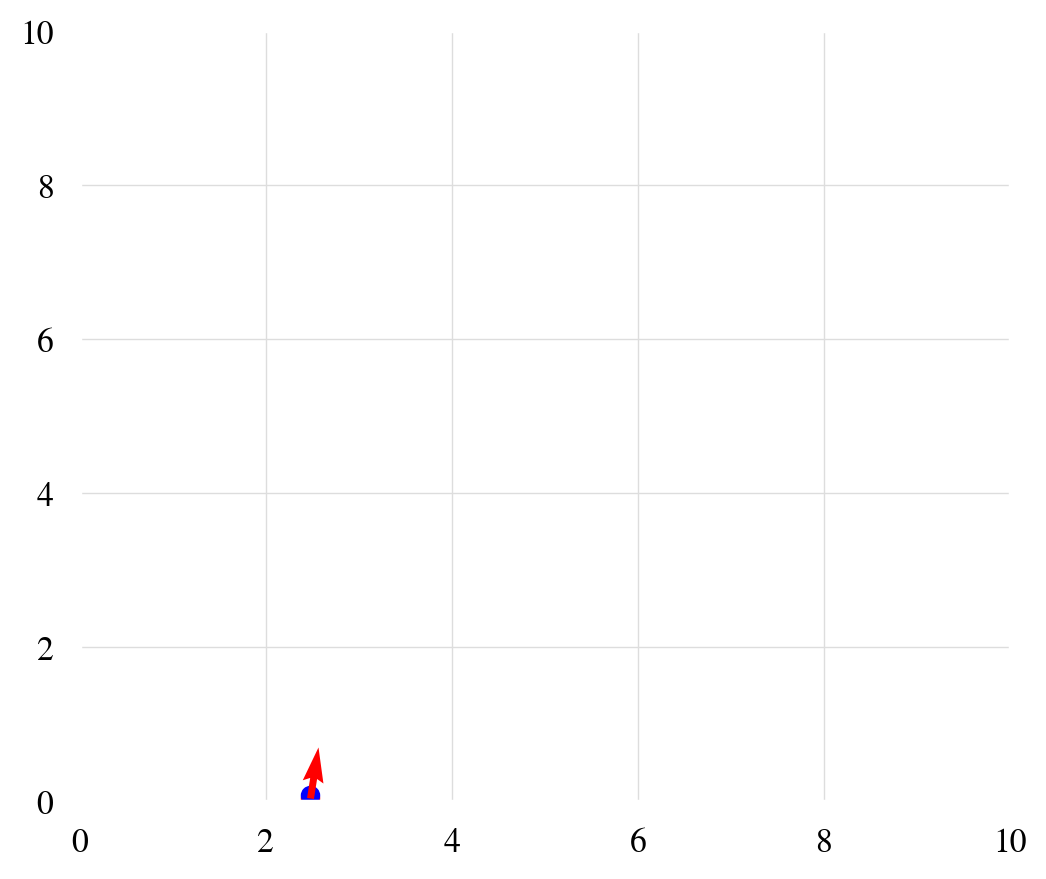

In [32]:
velocity1 = speedV * np.array([np.cos(phase), np.sin(phase)])

plt.scatter(position[0], position[1], color="red")
plt.scatter(center[0], center[1], color="blue")
plt.quiver(position[0], position[1], velocity1[0], velocity1[1], color="red")
plt.xlim(0, 10)
plt.ylim(0, 10)

In [37]:
centers[osciIdx]

array([2.47495319, 0.07579715])

In [34]:
center

array([2.47495319, 0.07579715])

In [6]:
speedV = 0.03

modelCentors = dict()
modelRadius = dict()

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    centers = np.zeros((1000, 2))
    radius = np.zeros(1000)
    # tracks = np.array([])

    for osciIdx in range(1000):
        position = singlePositionX[osciIdx]
        phase = singlePhaseTheta[osciIdx]
        point = omegaTheta[osciIdx]  # singlePointTheta[osciIdx]

        counts = max(20, abs(2 * np.pi // point))
        phaseChanges = np.arange(0, counts * point, point)

        trackX = position[0] + np.cumsum(speedV * np.cos(phase + phaseChanges))
        trackY = position[1] + np.cumsum(speedV * np.sin(phase + phaseChanges))

        center = np.mean(np.array([trackX, trackY]), axis=1)
        radiu = np.mean(np.sqrt(np.sum((np.array([trackX, trackY]) - center.reshape(2, 1)) ** 2, axis=0)))

        centers[osciIdx] = center
        radius[osciIdx] = radiu
        
        # tracks = np.concatenate([tracks, np.array([trackX, trackY])])
    
    centers = np.mod(centers, 10)
    modelCentors[key] = centers
    modelRadius[key] = radius

  0%|          | 0/234 [00:00<?, ?it/s]

In [120]:
from scipy.stats import kurtosis

maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):
    
    centers = modelCentors[f"{l:.3f}_{d0:.2f}"]
    radius = modelRadius[f"{l:.3f}_{d0:.2f}"]

    # 计算centers的峰度
    maps.loc[l, d0] = np.std(np.sqrt(np.sum(centers ** 2, axis=1)))
    
maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

<AxesSubplot:>

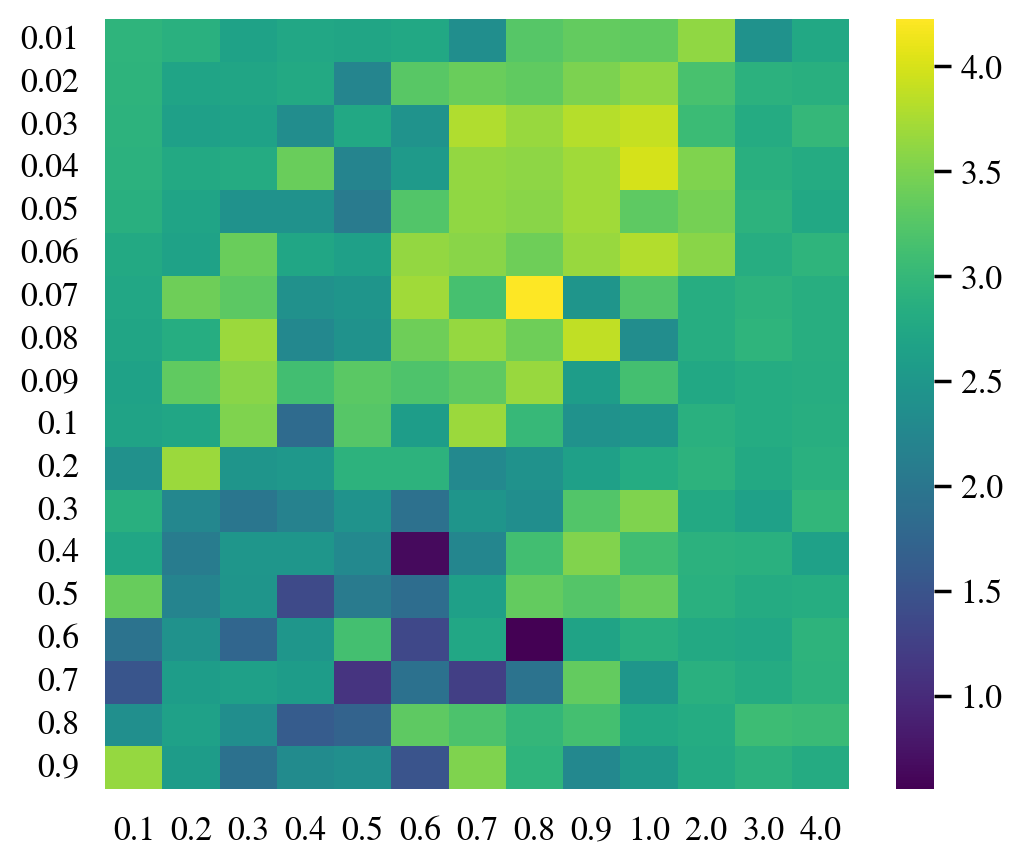

In [121]:
sns.heatmap(maps, cmap="viridis") # vmax=0.5

In [25]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

# @nb.njit
def nearby_nums(centers: np.ndarray):
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    dist = np.sqrt(np.sum(deltaX ** 2, axis=2))
    return np.sum(dist < 1, axis=1)

maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):
    
    centers = modelCentors[f"{l:.3f}_{d0:.2f}"]
    radius = modelRadius[f"{l:.3f}_{d0:.2f}"]

    maps.loc[l, d0] = np.mean(nearby_nums(centers))
    
maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

<AxesSubplot:>

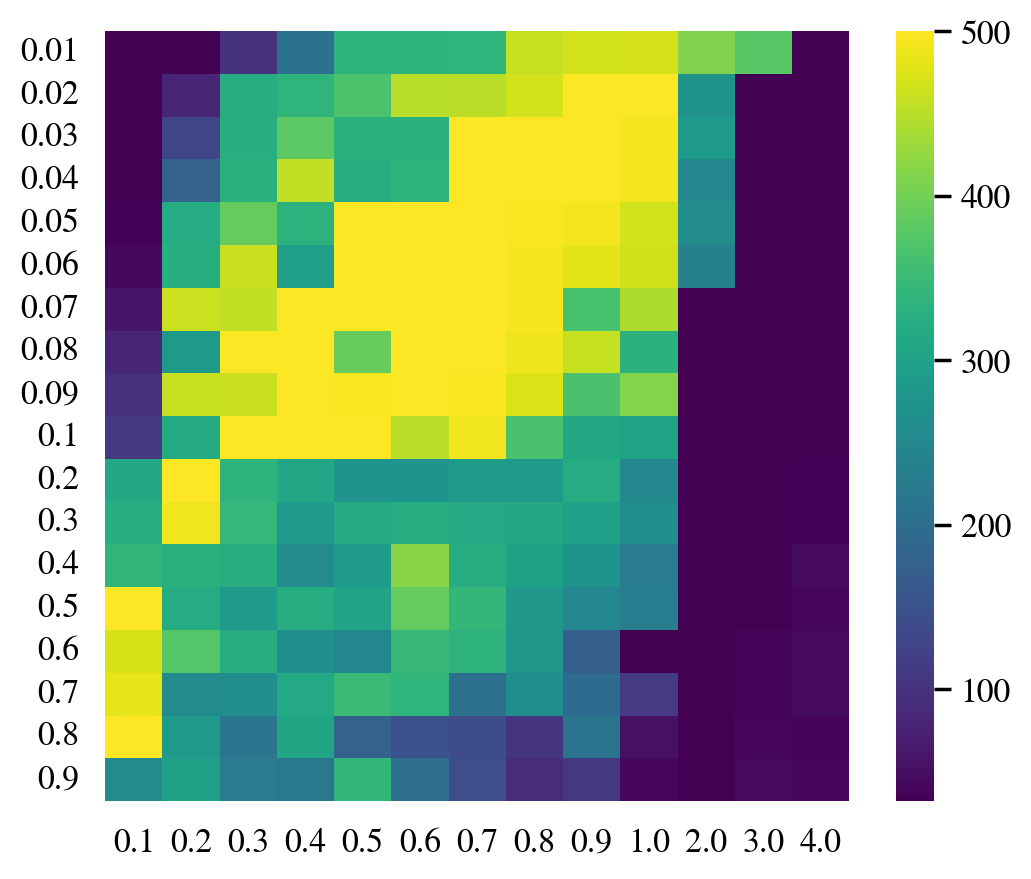

In [26]:
sns.heatmap(maps, cmap="viridis") # vmax=0.5

In [3]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

In [ ]:
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    positionX = totalPositionX[-1]
    phaseTheta = totalPhaseTheta[-1]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax2.add_artist(circle)
    ax2.scatter(
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato', alpha=0.5
    )
    ax2.scatter(
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue', alpha=0.5
    )
    ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(-1.1, 1.1)

    plt.savefig(f"./figs/{model}_2d_circle.png", dpi=200)
    plt.show()

for model in models:
    plot_last(model)

In [ ]:
shift = 0

def plot_last(key: str):

    l, d0 = key.split("_")
    l, d0 = float(l), float(d0)
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, dt=0.01, tqdm=False)

    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    lastPositionX = positionX[key]
    lastPhaseTheta = phaseTheta[key]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        lastPositionX[class1, 0], lastPositionX[class1, 1],
        np.cos(lastPhaseTheta[class1]), np.sin(lastPhaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        lastPositionX[class2, 0], lastPositionX[class2, 1],
        np.cos(lastPhaseTheta[class2]), np.sin(lastPhaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    hist, bins = np.histogram(lastPhaseTheta[class1], bins=100, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax2.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist), hist]), 
        color='tomato', alpha=0.5, edgecolor="tomato"
    )
    hist, bins = np.histogram(lastPhaseTheta[class2], bins=100, range=(-np.pi, np.pi))
    ax2.plot_surface(
        np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
        np.array([np.zeros_like(hist), hist]), 
        color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
    )
    ax2.set_xlabel(r"$\cos(\theta_I)$")
    ax2.set_ylabel(r"$\sin(\theta_I)$")

    plt.savefig(f"./figs/unitCircle/{model}.eps", dpi=250)
    plt.close()

for key in tqdm(positionX.keys()):
    plot_last(key)

In [9]:
def count_intervals(sequence, num_bins):
    min_val = 2 * np.pi
    max_val = 0

    # 使用numpy的histogram函数计算每个区间的计数
    hist, bins = np.histogram(sequence, bins=num_bins, range=(min_val, max_val))

    # 创建每个区间的标签
    labels = []
    for i in range(num_bins):
        labels.append('[{:.2f}, {:.2f})'.format(bins[i], bins[i+1]))

    return dict(zip(labels, hist))